In [59]:
pip install persim

You should consider upgrading via the '/Users/ryanhuang/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [69]:
# Import general utilities
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Import TDA utilities
from ripser import Rips
from tadasets import torus, sphere
import persim
from persim.landscapes import (
    PersLandscapeApprox,
    average_approx,
    snap_pl,
    plot_landscape,
    plot_landscape_simple
)

# Import Scikit-Learn tools
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split

import numpy as np
import gudhi as gd
import pandas as pd
import gudhi.representations
import matplotlib.pyplot as plt
import csv
import os

In [221]:
df = pd.read_csv("patient-subtype.csv")
directory = '/Users/ryanhuang/Downloads/csv/'
files = os.listdir(directory)
basal = []
her2 = []
lumA = []
lumB = []

for filename in files:
    if filename[len(filename)-3:] != "csv":
        continue
    df2 = df.loc[df['Patient_ID'] == filename[0:12], 'Subtype']
    f = os.path.join(directory, filename)
    X = np.loadtxt(f, delimiter=',')
    ac = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=1e12)
    d = ac.persistence()
    LS = gd.representations.Landscape(resolution=1000)
    dgm = LS.fit_transform([ac.persistence_intervals_in_dimension(1)])
    if df2.isin(["BRCA_Basal"]).any():
        basal.append(dgm)
    elif df2.isin(["BRCA_Her2"]).any():
        her2.append(dgm)
    elif df2.isin(["BRCA_LumA"]).any():
        lumA.append(dgm)
    elif df2.isin(["BRCA_LumB"]).any():
        lumB.append(dgm)

[   0.          400.92126955 3765.06477809 ...    0.            0.
    0.        ]


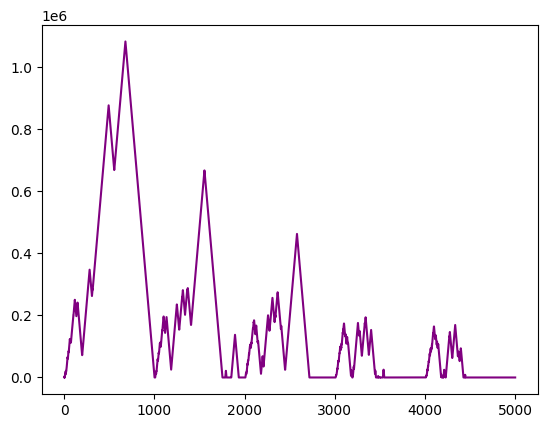

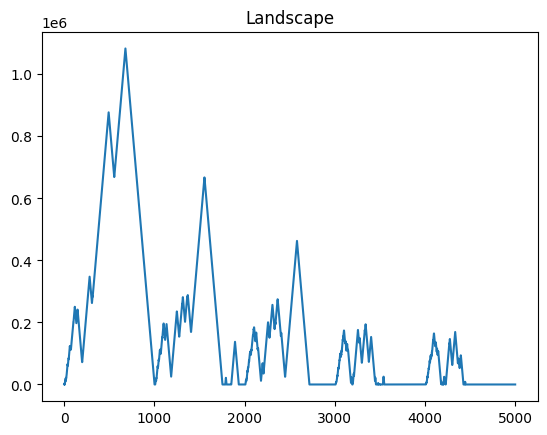

In [174]:
print(basal[1][0])
x = [i for i in range(5000)]
plt.plot(x, basal[1][0], color='purple')
plt.show()
L = basal[1]
# plt.plot(L[0][:1000])
# plt.plot(L[0][1000:2000])
# plt.plot(L[0][2000:3000])
plt.plot(L[0][0:5000])
plt.title("Landscape")
plt.show()

In [220]:
w = 1000 # entire landscape has 5000 pts

# Instantiate zero-padded arrays
ls_basal = np.zeros((len(basal), w))
ls_her2 = np.zeros((len(her2), w))
ls_lumA = np.zeros((len(lumA), w))
ls_lumB = np.zeros((len(lumB), w))

# retrieve top 75 values in landscape (out of 1000)
for i in range(len(basal)):
    top75 = sorted(basal[i][0][0:1000])[-75:]
    ls_basal[i] = basal[i][0][0:1000] # just this line for regular
    for j in range(len(ls_basal[i])):
        if ls_basal[i][j] not in top75:
            ls_basal[i][j]=0
    
for i in range(len(her2)):
    top75 = sorted(her2[i][0][0:1000])[-75:]
    ls_her2[i] = her2[i][0][0:1000] # just this line for regular
    for j in range(len(ls_her2[i])):
        if ls_her2[i][j] not in top75:
            ls_her2[i][j]=0
    ls_her2[i] = her2[i][0][0:1000]
    
for i in range(len(lumA)):
    top75 = sorted(lumA[i][0][0:1000])[-75:]
    ls_lumA[i] = lumA[i][0][0:1000] # just this line for regular
    for j in range(len(ls_lumA[i])):
        if ls_lumA[i][j] not in top75:
            ls_lumA[i][j]=0
    
for i in range(len(lumB)):
    top75 = sorted(lumB[i][0][0:1000])[-75:]
    ls_lumB[i] = lumB[i][0][0:1000] # just this line for regular
    for j in range(len(ls_lumB[i])):
        if ls_lumB[i][j] not in top75:
            ls_lumB[i][j]=0

print('Basal:', ls_basal.shape)
print('Her2:', ls_her2.shape)
print('LumA:', ls_lumA.shape)
print('LumB:', ls_lumB.shape)

(87, 1, 5000)
Basal: (87, 1000)
Her2: (40, 1000)
LumA: (313, 1000)
LumB: (94, 1000)


In [215]:
# Instantiate PCA solver
pca_basal = PCA(n_components=2)

# Compute PCA
pca_basal.fit_transform(ls_basal)

# Define components
comp_basal = pca_basal.components_

#----------------------------------

# Instantiate PCA solver
pca_her2 = PCA(n_components=2)

# Compute PCA
pca_her2.fit_transform(ls_her2)

# Define components
comp_her2 = pca_her2.components_

#----------------------------------

# Instantiate PCA solver
pca_lumA = PCA(n_components=2)

# Compute PCA
pca_lumA.fit_transform(ls_lumA)

# Define components
comp_lumA = pca_lumA.components_

#----------------------------------

# Instantiate PCA solver
pca_lumB = PCA(n_components=2)

# Compute PCA
pca_lumB.fit_transform(ls_lumB)

# Define components
comp_lumB = pca_lumB.components_

In [217]:
print('Singular values for basal dataset:', pca_basal.singular_values_)
print('Singular values for her2 dataset:', pca_her2.singular_values_)
print('Singular values for lumA dataset:', pca_lumA.singular_values_)
print('Singular values for lumB dataset:', pca_lumB.singular_values_)

Singular values for basal dataset: [93659909.650159   77379040.34489578]
Singular values for her2 dataset: [1.47064915e+08 8.09335787e+07]
Singular values for lumA dataset: [1.13855148e+08 1.04318771e+08]
Singular values for lumB dataset: [1.20049897e+08 7.40463273e+07]


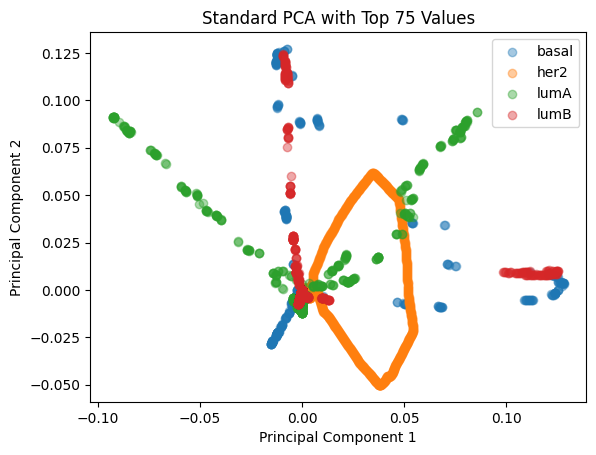

In [219]:
plt.figure()
plt.scatter(comp_basal[0], comp_basal[1], label='basal', alpha=0.4)
plt.scatter(comp_her2[0], comp_her2[1], label='her2', alpha=0.4)
plt.scatter(comp_lumA[0], comp_lumA[1], label='lumA', alpha=0.4)
plt.scatter(comp_lumB[0], comp_lumB[1], label='lumB', alpha=0.4)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Standard PCA with Top 75 Values')
plt.legend()